Epoch 50: 100%|██████████| 212/212 [12:00<00:00,  3.40s/batch, D_Fake_Loss=0.689, D_Real_Loss=0.698, d_loss=1.39, g_loss=1.02] 


Training finished.
Models saved at epoch 50 with batch size 16 and image size 100


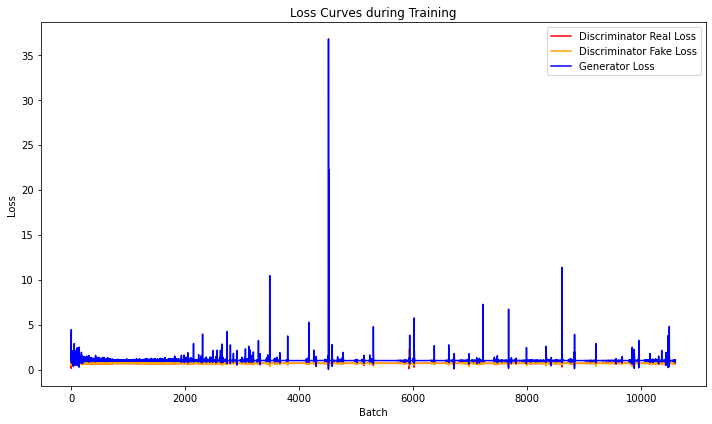

In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast  
from tqdm import tqdm 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
####################
# Dataset Class 
####################


class XRayDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None):
        """
        Initializes dataset with CSV file and image folder.
        """
        self.csv = pd.read_csv(csv_file)
        self.img_folder = img_folder
        self.transform = transform
        self.pairs = self.csv.groupby('uid')
        self.valid_uids = self.check_integrity()

    def check_integrity(self):
        """
        Ensure we have both 'Frontal' and 'Lateral' images for each UID.
        """
        valid_uids = []
        for uid, group in self.pairs:
            frontal_data = group[group['projection'] == 'Frontal']
            lateral_data = group[group['projection'] == 'Lateral']
            if not frontal_data.empty and not lateral_data.empty:
                valid_uids.append(uid)
        return valid_uids

    def __len__(self):
        return len(self.valid_uids)

    def __getitem__(self, idx):
        """
        Fetch the images for a specific UID.
        """
        group_key = self.valid_uids[idx]
        uid = self.pairs.get_group(group_key)

        frontal_img_path = os.path.join(self.img_folder, uid[uid['projection'] == 'Frontal']['filename'].values[0])
        lateral_img_path = os.path.join(self.img_folder, uid[uid['projection'] == 'Lateral']['filename'].values[0])

        frontal_img = cv2.imread(frontal_img_path)
        lateral_img = cv2.imread(lateral_img_path)

        if frontal_img is None or lateral_img is None:
            print(f"Error reading image: {frontal_img_path if frontal_img is None else lateral_img_path}")
            return None, None 

        frontal_img_resized = cv2.resize(frontal_img, (512, 512))
        lateral_img_resized = cv2.resize(lateral_img, (512, 512))

        frontal_img_tensor = torch.tensor(cv2.cvtColor(frontal_img_resized, cv2.COLOR_BGR2RGB), dtype=torch.float32)
        lateral_img_tensor = torch.tensor(cv2.cvtColor(lateral_img_resized, cv2.COLOR_BGR2RGB), dtype=torch.float32)
        frontal_img_tensor = frontal_img_tensor.permute(2, 0, 1)  
        lateral_img_tensor = lateral_img_tensor.permute(2, 0, 1)  


        return frontal_img_tensor, lateral_img_tensor

####################
# Discriminator2D
####################

# Define the Dense Block
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(nn.Sequential(
                nn.Conv2d(in_channels + i * growth_rate, growth_rate, kernel_size=3, padding=1),
                nn.InstanceNorm2d(growth_rate),
                nn.ReLU(inplace=True)
            ))

    def forward(self, x):
        for layer in self.layers:
            new_features = layer(x)
            x = torch.cat([x, new_features], dim=1)
        return x

# Define the Basic3D Block
class Basic3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Basic3D, self).__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

# Define 2D to 3D Connection (Connection-C)
class Connection2Dto3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Connection2Dto3D, self).__init__()
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv3d = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv2d(x)
        x = x.unsqueeze(2)
        x = self.conv3d(x)
        return x

class Generator(nn.Module):
    def __init__(self, in_channels, growth_rate, num_dense_layers, out_channels, image_size):
        super(Generator, self).__init__()

        self.image_size = image_size
        self.num_upconv_layers = int(torch.log2(torch.tensor(image_size // 4)).item())

        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1),
            DenseBlock(growth_rate, growth_rate, num_dense_layers),
            nn.Conv2d(growth_rate * (num_dense_layers + 1), growth_rate, kernel_size=3, stride=2, padding=1)  # Compression
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1),
            DenseBlock(growth_rate, growth_rate, num_dense_layers),
            nn.Conv2d(growth_rate * (num_dense_layers + 1), growth_rate, kernel_size=3, stride=2, padding=1)  # Compression
        )

        self.connection_a = Connection2Dto3D(growth_rate, growth_rate)
        self.connection_b = nn.Conv3d(growth_rate * 2, growth_rate, kernel_size=3, padding=1)
        self.connection_c = nn.Conv3d(growth_rate, growth_rate, kernel_size=3, padding=1)

        self.upconv_layers = nn.ModuleList()
        for _ in range(self.num_upconv_layers):
            self.upconv_layers.append(
                nn.Sequential(
                    nn.ConvTranspose3d(growth_rate, growth_rate, kernel_size=4, stride=2, padding=1),
                    nn.InstanceNorm3d(growth_rate),
                    nn.ReLU(inplace=True)
                )
            )

        self.final_layer = nn.Conv3d(growth_rate, out_channels, kernel_size=3, padding=1)

    def forward(self, x1, x2):

        x1 = self.encoder1(x1)
        x2 = self.encoder2(x2)
        x1 = self.connection_a(x1)
        x2 = self.connection_a(x2)
        x = torch.cat([x1, x2], dim=1)
        x = self.connection_b(x)
        for upconv in self.upconv_layers:
            x = upconv(x)

        x = self.final_layer(x)
        return x


####################
# Discriminator2D
####################
class Discriminator2D(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator2D, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.AdaptiveAvgPool2d((1,1))  
        )
        
    def forward(self, x):
        out = self.model(x)
        return out.view(-1) 

####################
# Loss Functions
####################
def projection_consistency_loss(generated_3d, frontal_input, lateral_input):
    """
    Calculate loss by comparing projections of the generated 3D shape 
    with the input frontal and lateral images.
    """
    frontal_input = frontal_input.mean(dim=1, keepdim=True)
    lateral_input = lateral_input.mean(dim=1, keepdim=True) 
    frontal_projection = generated_3d.sum(dim=2)
    lateral_projection = generated_3d.sum(dim=4) 

    frontal_projection = F.interpolate(frontal_projection, size=(512, 512), mode="bilinear", align_corners=False)
    lateral_projection = F.interpolate(lateral_projection, size=(512, 512), mode="bilinear", align_corners=False)

    frontal_loss = F.mse_loss(frontal_projection, frontal_input)
    lateral_loss = F.mse_loss(lateral_projection, lateral_input)

    return frontal_loss + lateral_loss, frontal_projection, lateral_projection

def shape_coherence_loss(generated_3d):
    """
    Regularize the 3D shape using Total Variation (TV) Loss to ensure smoothness.
    """
    # Differences along each dimension (TV loss components)
    dx = torch.abs(generated_3d[:, :, 1:, :, :] - generated_3d[:, :, :-1, :, :]).mean()
    dy = torch.abs(generated_3d[:, :, :, 1:, :] - generated_3d[:, :, :, :-1, :]).mean()
    dz = torch.abs(generated_3d[:, :, :, :, 1:] - generated_3d[:, :, :, :, :-1]).mean()
    
    # Total TV loss
    return dx + dy + dz

def adversarial_loss(disc_output, target_is_real=True):
    if target_is_real:
        # target of 1.0 for real
        targets = torch.ones_like(disc_output, device=disc_output.device)
    else:
        # target of 0.0 for fake
        targets = torch.zeros_like(disc_output, device=disc_output.device)
    return F.binary_cross_entropy_with_logits(disc_output, targets)

def compute_snr(real_img, fake_img):
    # Both in same scale, assume normalized 0-1
    mse = torch.mean((real_img - fake_img)**2)
    signal_power = torch.mean(real_img**2)
    if mse == 0:
        return float('inf')
    snr_value = 10 * math.log10((signal_power / mse).item())
    return snr_value


if __name__ == '__main__':

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Paths and parameters
    img_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_11/Adwait/Work_on_this_code/images/images_normalized/'
    csv_file = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_11/Adwait/Work_on_this_code/indiana_projections.csv'
    
    batch_size = 32
    num_epochs = 90
    lambda_proj = 1.0
    lambda_shape = 0.01
    lambda_adv = 0.9

    dataset = XRayDataset(csv_file=csv_file, img_folder=img_folder)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    generator = Generator3D().to(device)
    discriminator = Discriminator2D(input_channels=3).to(device)
    generator = nn.DataParallel(Generator3D()).to(device)
    discriminator = nn.DataParallel(Discriminator2D(input_channels=3)).to(device)


    scaler = GradScaler()
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    all_loss_history = {
    "D Real Frontal Loss": [],
    "D Real Lateral Loss": [],
    "D Fake Frontal Loss": [],
    "D Fake Lateral Loss": [],
    "D Total Loss": [],
    "G Adversarial Loss": [],
    "G Projection Loss": [],
    "G Shape Coherence Loss": [],
    "G Total Loss": [],
    "D Real Loss ":[],
    "D Fake Loss":[],
    }

# Training loop
    best_loss = float('inf')
    best_loss_G = float('inf')
    best_loss_S = float('inf')
    best_loss_A = float('inf')
    for epoch in range(num_epochs):
        with tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as tepoch:
            for i, (frontal_img_tensor, lateral_img_tensor) in enumerate(tepoch):
                frontal_img_tensor = frontal_img_tensor.to(device)
                lateral_img_tensor = lateral_img_tensor.to(device)

                # ----------------------
                # Train Discriminator
                # ----------------------
                d_optimizer.zero_grad()

                with autocast():  # Mixed precision
                    # Real losses
                    real_frontal_out = discriminator(frontal_img_tensor)
                    d_real_frontal_loss = adversarial_loss(real_frontal_out, target_is_real=True)

                    real_lateral_out = discriminator(lateral_img_tensor)
                    d_real_lateral_loss = adversarial_loss(real_lateral_out, target_is_real=True)

                    discriminator_real_loss = (d_real_frontal_loss+d_fake_lateral_loss)/2

                    # Fake losses
                    with torch.no_grad():
                        generated_3d = generator(frontal_img_tensor, lateral_img_tensor)
                    _, fake_frontal_proj, fake_lateral_proj = projection_consistency_loss(
                        generated_3d, frontal_img_tensor, lateral_img_tensor
                    )
                    fake_frontal_proj = fake_frontal_proj.expand(-1, 3, -1, -1)
                    fake_lateral_proj = fake_lateral_proj.expand(-1, 3, -1, -1)

                    fake_frontal_out = discriminator(fake_frontal_proj)
                    d_fake_frontal_loss = adversarial_loss(fake_frontal_out, target_is_real=False)

                    fake_lateral_out = discriminator(fake_lateral_proj)
                    d_fake_lateral_loss = adversarial_loss(fake_lateral_out, target_is_real=False)

                    discriminator_fake_loss = (d_fake_frontal_loss+d_fake_lateral_loss)/2

                    # Total discriminator loss
                    d_loss = (
                        d_real_frontal_loss + d_real_lateral_loss + d_fake_frontal_loss + d_fake_lateral_loss
                    ) / 4
                    d_loss += 1e-4 * sum(p.pow(2.0).sum() for p in discriminator.parameters())

                # Backpropagate and update discriminator
                scaler.scale(d_loss).backward()
                scaler.step(d_optimizer)
                scaler.update()

                # ----------------------
                # Train Generator
                # ----------------------
                g_optimizer.zero_grad()

                with autocast():  # Mixed precision
                    # Projection and shape losses
                    proj_loss, fake_frontal_proj, fake_lateral_proj = projection_consistency_loss(
                        generated_3d, frontal_img_tensor, lateral_img_tensor
                    )
                    shape_loss = shape_coherence_loss(generated_3d)

                    # Adversarial loss
                    fake_frontal_proj = fake_frontal_proj.expand(-1, 3, -1, -1)
                    fake_lateral_proj = fake_lateral_proj.expand(-1, 3, -1, -1)
                    g_frontal_out = discriminator(fake_frontal_proj)
                    g_lateral_out = discriminator(fake_lateral_proj)
                    g_adv_loss = (adversarial_loss(g_frontal_out, target_is_real=True) +
                                adversarial_loss(g_lateral_out, target_is_real=True)) / 2

                    # Dynamic loss weights
                    lambda_proj = 1.0 / (proj_loss.item() + 1e-8)
                    lambda_shape = 0.1 / (shape_loss.item() + 1e-8)
                    lambda_adv = 1.0 / (g_adv_loss.item() + 1e-8)
                    total_weight = lambda_proj + lambda_shape + lambda_adv
                    lambda_proj /= total_weight
                    lambda_shape /= total_weight
                    lambda_adv /= total_weight

                    # Total generator loss
                    total_g_loss = lambda_adv * g_adv_loss + lambda_proj * proj_loss + lambda_shape * shape_loss
                    total_g_loss += 1e-4 * sum(p.pow(2.0).sum() for p in generator.parameters())

                # Backpropagate and update generator
                scaler.scale(total_g_loss).backward()
                scaler.step(g_optimizer)
                scaler.update()
                
                #----------------------
                # Store all Losses
                #----------------------
                
                all_loss_history["D Real Frontal Loss"].append(d_real_frontal_loss.item())
                all_loss_history["D Real Lateral Loss"].append(d_real_lateral_loss.item())
                all_loss_history["D Fake Frontal Loss"].append(d_fake_frontal_loss.item())
                all_loss_history["D Fake Lateral Loss"].append(d_fake_lateral_loss.item())
                all_loss_history["D Total Loss"].append(d_loss.item())
                all_loss_history["G Adversarial Loss"].append(g_adv_loss.item())
                all_loss_history["G Projection Loss"].append(proj_loss.item())
                all_loss_history["G Shape Coherence Loss"].append(shape_loss.item())
                all_loss_history["G Total Loss"].append(total_g_loss.item())
                all_loss_history["D Real Loss"].append(discriminator_real_loss.item())
                all_loss_history["D Fake Loss"].append(discriminator_fake_loss.item())


                # ----------------------
                # Update TQDM Postfix
                # ----------------------
                tepoch.set_postfix({
                    "D Loss": f"{d_loss.item():.4f}",
                    "G Loss": f"{total_g_loss.item():.4f}",
                    "Proj Loss": f"{proj_loss.item():.4f}",
                    "Shape Loss": f"{shape_loss.item():.4f}",
                    "Adv Loss": f"{g_adv_loss.item():.4f}",
                })

                # Save the best generator
                if proj_loss.item() < best_loss:
                    best_loss = proj_loss.item()
                    torch.save(generator.state_dict(), "best_generator_projection.pth")
                if total_g_loss.item() < best_loss_G:
                    best_loss = total_g_loss.item()
                    torch.save(generator.state_dict(), "best_generator_G_Loss.pth")
                if shape_loss.item() < best_loss_S:
                    best_loss = shape_loss.item()
                    torch.save(generator.state_dict(), "best_generator_Shape_Loss.pth")
                if g_adv_loss.item() < best_loss_A:
                    best_loss = g_adv_loss.item()
                    torch.save(generator.state_dict(), "best_generator_ADV_Loss.pth")



In [2]:
#AROUND 12 Minutes per epoch so take 15 mins for each epoch while submitting a batch job :)
#ALSO this config takes nearly 70gb vram so its like A100 or 2 L40S.

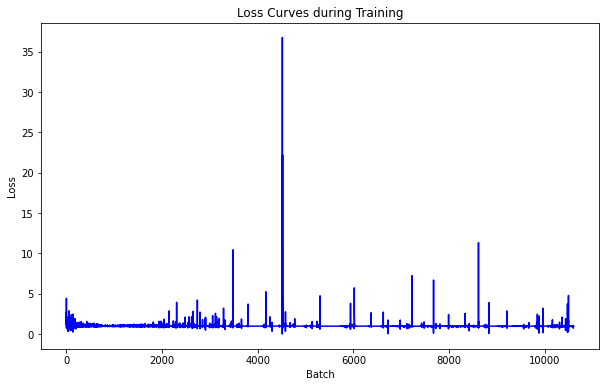

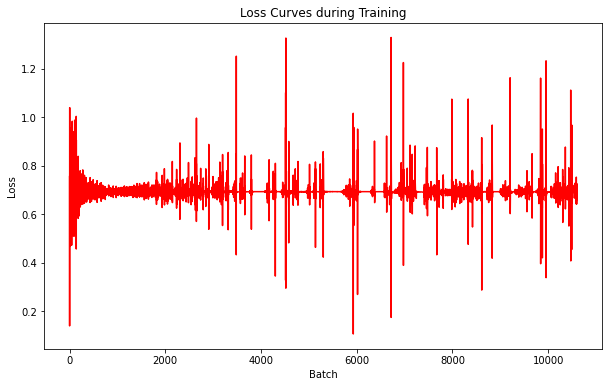

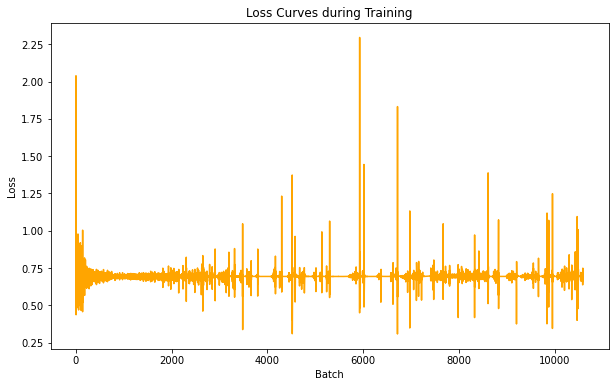

In [3]:
    plt.figure(figsize=(10, 6))
    plt.plot(total_g_loss, label='Generator Loss', color='b')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curves during Training')
    plt.show()
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(discriminator_real_loss, label='Discriminator Real Loss', color='r')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curves during Training')
    plt.show()
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(discriminator_fake_loss, label='Discriminator Fake Loss', color='orange')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curves during Training')
    plt.show()

In [ ]:
## THESE 3 PLOTS ARE GENERATOR LOSS , DISCRIMINATOR REAL, and DISCRIMINATOR FAKE LOSS
# The loss plot included in the report was trained on images with size (512,512) and 150 Epochs